In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:

def plot_train_charts(
    csv_path: str = "train_chart.csv",
    x_min: float = None,
    x_max: float = None,
    figsize_per_corridor: float = 2.8,
    seed: int = 42,
    dpi: int = 120,
    special_train: int = -1,
    corridor_nm = []
):
    """
    Plot train charts (chainage vs time) with one subplot per corridor_id,
    sharing the same x-axis and stacked vertically.

    Parameters
    ----------
    csv_path : str
        Path to the input CSV. Must contain columns: time, corridor_id, train, chainage.
    x_min : float, optional
        Minimum time (x-axis) to display. If None, uses min(time) in the data.
    x_max : float, optional
        Maximum time (x-axis) to display. If None, uses max(time) in the data.
    figsize_per_corridor : float, optional
        Height (in inches) allocated per corridor subplot. Total figure height scales
        as n_corridors * figsize_per_corridor.
    seed : int, optional
        Random seed to make train color assignments reproducible across runs.
    dpi : int, optional
        DPI for the output figure.

    Returns
    -------
    matplotlib.figure.Figure
        The created figure.
    matplotlib.axes.Axes or numpy.ndarray
        The axes object(s).
    """
    # --- Load ---------------------------------------------------------------
    df = pd.read_csv(csv_path)

    # Basic validation of expected columns
    required_cols = {"time", "corridor_id", "train", "chainage"}
    missing = required_cols.difference(df.columns)
    if missing:
        raise ValueError(f"CSV is missing required columns: {missing}")

    # Coerce numeric types (defensive)
    df["time"] = pd.to_numeric(df["time"], errors="coerce")
    df["corridor_id"] = pd.to_numeric(df["corridor_id"], errors="coerce")
    df["train"] = pd.to_numeric(df["train"], errors="coerce")
    df["chainage"] = pd.to_numeric(df["chainage"], errors="coerce")
    df = df.dropna(subset=["time", "corridor_id", "train", "chainage"])

    # Determine x-axis extents
    if x_min is None:
        x_min = float(df["time"].min())
    if x_max is None:
        x_max = float(df["time"].max())
    if x_min >= x_max:
        raise ValueError("x_min must be less than x_max.")

    # Filter to requested time window
    df = df[(df["time"] >= x_min) & (df["time"] <= x_max)]

    # Get corridor list (sorted for stable ordering)
    corridors = sorted(df["corridor_id"].unique())
    n_corridors = len(corridors)
    if n_corridors == 0:
        raise ValueError("No data within the specified time window.")

    # Global color assignment per train for consistency across subplots
    rng = np.random.default_rng(seed)
    trains = sorted(df["train"].unique())
    # Use a large qualitative palette as base, then shuffle for randomness
    base_colors = plt.get_cmap("tab20").colors
    # If more trains than base colors, tile the palette
    color_pool = (list(base_colors) * ((len(trains) // len(base_colors)) + 1))[:len(trains)]
    rng.shuffle(color_pool)
    #print(color_pool)
    train_to_color = dict(zip(trains, color_pool))

    # --- Plot ---------------------------------------------------------------
    fig_height = max(2.0, n_corridors * figsize_per_corridor)
    fig, axes = plt.subplots(
        n_corridors, 1, sharex=True, figsize=(10, fig_height), dpi=dpi
    )
    if n_corridors == 1:
        axes = np.array([axes])  # make iterable

    for ax, cid in zip(axes, corridors):
        d = df[df["corridor_id"] == cid].copy()

        # Sort each train series by time to ensure continuous lines
        for train_id, g in d.groupby("train"):
            g = g.sort_values("time")
            if train_id != special_train:
                ax.plot(
                    g["time"],
                    g["chainage"],
                    color=train_to_color.get(train_id, "black"),
                    linewidth=1.5,
                    alpha=0.9,
                    label=f"Train {train_id}",
                )
            else:
                ax.plot(
                    g["time"],
                    g["chainage"],
                    color=(1.0, 0.0, 0.0),
                    linewidth=3,
                    alpha=1.0,
                    label=f"Train {train_id}",
                )

        ax.set_ylabel("Chainage (km)")
        cnm = corridor_nm[int(cid)]
        ax.set_title(f"{cnm} Corridor")
        ax.grid(True, linestyle=":", alpha=0.6)

        # Optional: legend; place outside right to reduce clutter
        # Hide duplicate labels if many trains share the same id
        handles, labels = ax.get_legend_handles_labels()
        # Deduplicate labels
        unique = dict(zip(labels, handles))
        """
        ax.legend(
            unique.values(),
            unique.keys(),
            loc="center left",
            bbox_to_anchor=(1.02, 0.5),
            fontsize=8,
            frameon=False,
            ncol=1,
        )"""

    axes[-1].set_xlabel("Simulation Clock (hr)")
    # Apply x-limits to all axes via the shared x-axis
    axes[-1].set_xlim(x_min, x_max)

    plt.tight_layout()
    return fig, axes



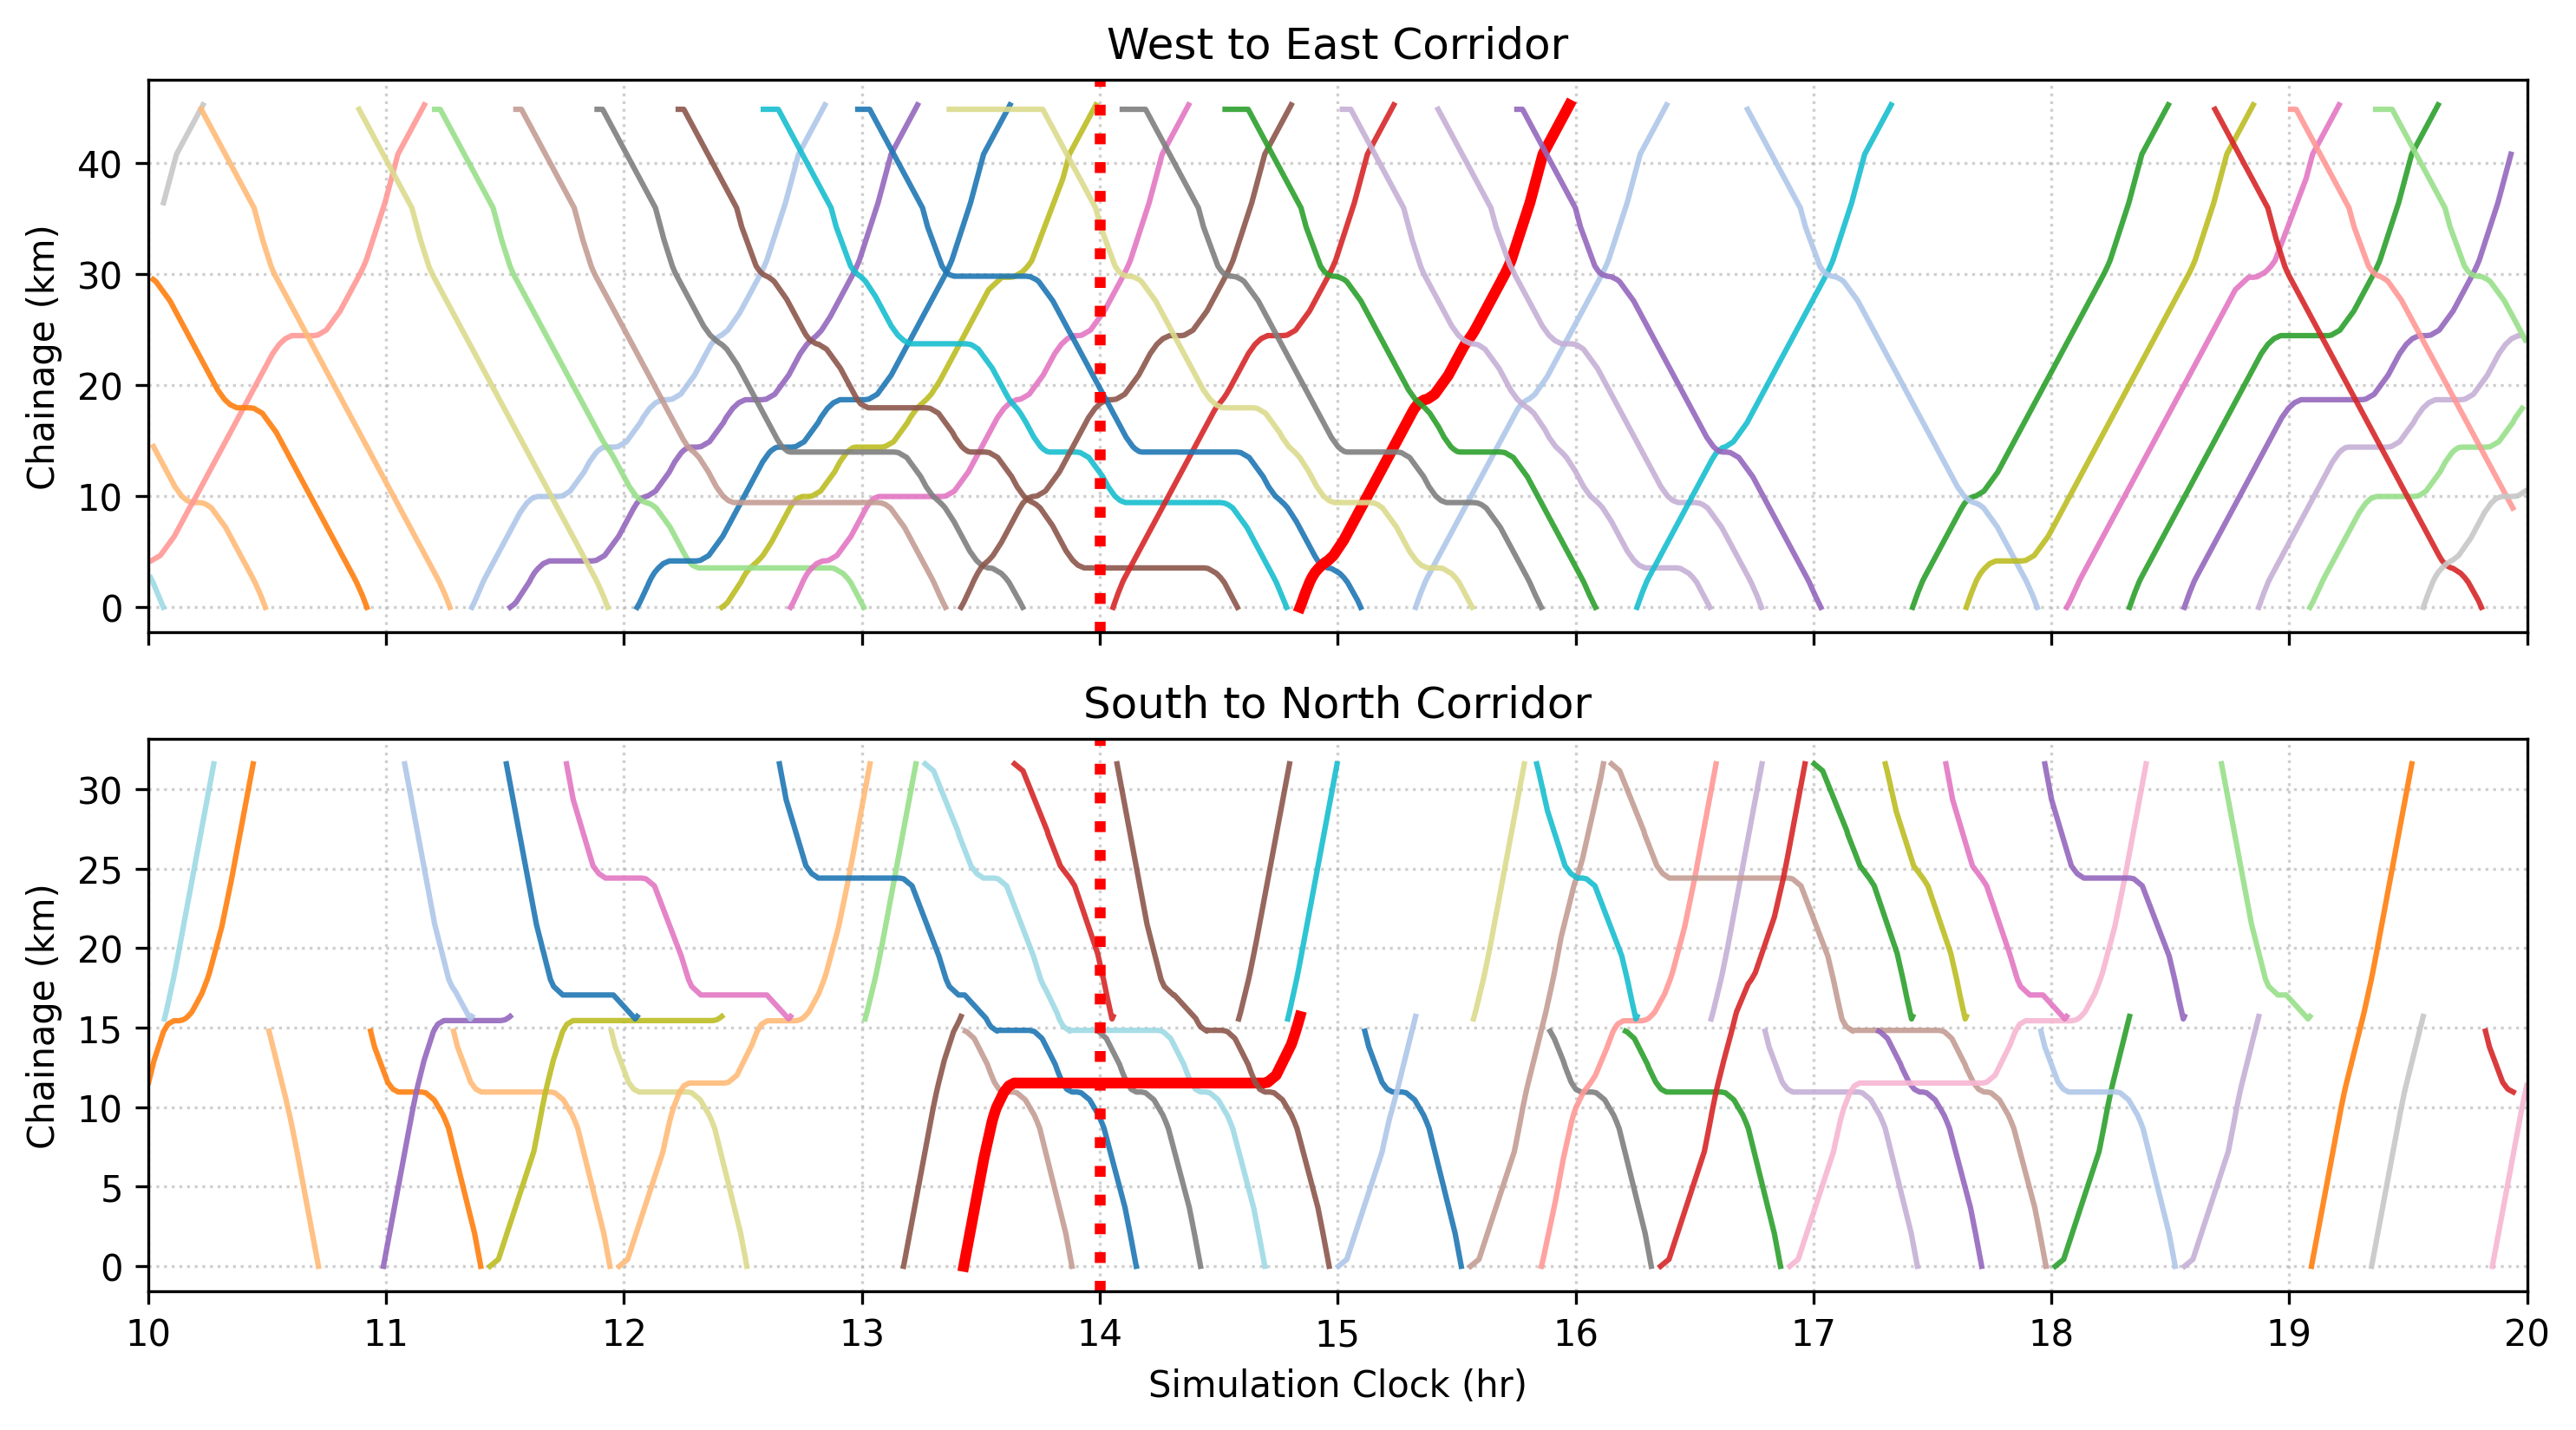

In [3]:

fig, axes = plot_train_charts(
    csv_path="train_chart.csv",  # path to your uploaded data
    x_min=10,                   # left extent of the time axis
    x_max=20,                  # right extent of the time axis
    figsize_per_corridor=2.8,    # adjust subplot height per corridor
    seed=123,                    # optional: change for different random colors
    dpi=300,                      # figure DPI
    special_train=44,
    corridor_nm=["West to East", "South to North"]
)
plt.xticks(np.arange(10, 21, 1))

# Add thick red dotted vertical line at x=12.5 on both subplots
for ax in axes:
    ax.axvline(x=14, color='red', linestyle=':', linewidth=3)


plt.show()